In [ ]:
from FISHClass.datasets import MYCN
from torch.utils.data import DataLoader
from FISHClass.utils.visualize import gridPlot
import h5py
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import pandas as pd
import random

CELLLINE_BASE = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/CELLINES"

In [ ]:
POSITIVE_CELLLINE = "CLB-MA"
NEGATIVE_CELLLINE = "SK-N-MM"

kept_dict = {}
for CELLLINE in [POSITIVE_CELLLINE, NEGATIVE_CELLLINE]:
    
    with h5py.File(f"{CELLLINE_BASE}/{CELLLINE}/{CELLLINE}.h5", "r") as fin:
        X = np.array(fin[CELLLINE]["X"])

    sizes, masks = [], []
    for im in X:
        
        mask = np.zeros_like(im[..., 0])
        mask[im[..., 2]!=0] = 1
        sizes.append(mask.sum())
        masks.append(mask.astype(bool))

    sizes = np.array(sizes) 
    masks = np.array(masks)

    low = np.quantile(sizes, 0.25)
    high = np.quantile(sizes, 0.75)

    keep = X[np.logical_and(sizes>low, sizes<high)]
    discard = X[np.logical_or(sizes<low, sizes>high)]
    masks_keep = masks[np.logical_and(sizes>low, sizes<high)]

    kept_dict[CELLLINE] = {"X": keep, "masks": masks_keep}

In [ ]:
#degradations blurr, brightness, noise

class BrightnessAdjust():

    def adjust(self, img, mask, change_vals=[1, 1, 1]):
        
        ret = img.copy()
        
        for n, v in enumerate(change_vals):
            
            ret[..., n] = ret[..., n]*v
            
        return np.clip(ret, 0, 1)


class BlurrAdjust():
    
    def adjust(self, img, mask, sig=0):
            
        ret = np.zeros_like(img)
        img = cv2.GaussianBlur(img, ksize=(63,63), sigmaX=sig, sigmaY=sig)
        ret[mask] = img[mask]
        ret = np.clip(ret, 0, 1)
        
        return ret


class NoiseAdjust():
    
    def adjust(self, img, mask, sig):
        
        noise = torch.normal(0, sig, img.shape).numpy()

        noise[mask==0] = 0
        
        img = np.clip(img + noise, 0, 1)

        return img
    

In [ ]:
idx = 2
img = kept_dict[POSITIVE_CELLLINE]["X"][idx]
mask = kept_dict[POSITIVE_CELLLINE]["masks"][idx]

plt.imshow(img[...,0]); plt.show()
plt.imshow(mask); plt.show()

In [ ]:
br = BrightnessAdjust()
bl = BlurrAdjust()
no = NoiseAdjust()

In [ ]:
bright = br.adjust(img, mask, change_vals=[2,4,0.5])
blurr = bl.adjust(img, mask, sig=2)
noise = no.adjust(img, mask, sig=.1)

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(bright)
ax[1].imshow(blurr)
ax[2].imshow(noise)

In [ ]:
BRIGHT = [2**(i) for i in range(-2,3,2)]
BLURR = [0.001, 2]
NOISE = [0, .2]

fig, ax = plt.subplots(1, len(BRIGHT), figsize=(15,4))
for i, B in enumerate(BRIGHT):
    ax[i].imshow(br.adjust(img, mask, change_vals=[B,B,B]))
    
fig, ax = plt.subplots(1, len(BLURR), figsize=(15,4))
for i, B in enumerate(BLURR):
    ax[i].imshow(bl.adjust(img, mask, sig=B))
    
fig, ax = plt.subplots(1, len(NOISE), figsize=(15,4))
for i, B in enumerate(NOISE):
    ax[i].imshow(no.adjust(img, mask, sig=B))
    

In [ ]:
rets = []
for key, item in kept_dict.items():
    
    X = item["X"][:100]
    masks = item["masks"][:100]
    
    br = BrightnessAdjust()
    bl = BlurrAdjust()
    no = NoiseAdjust()

    for im, mask in zip(X, masks):
        
        for bl_c, BL in zip([0, 1], BLURR):
            for br_c, BR in zip(["LOW", "NORMAL", "HIGH"], BRIGHT):
                for no_c, NO in zip([0, 1], NOISE):
                    ret = no.adjust(bl.adjust(br.adjust(im, mask, change_vals=[BR, BR, BR]), mask, sig=BL), mask, sig=NO)
                    rets.append({"image": ret, "code": f"BR:{br_c}_BL:{bl_c}_NO:{no_c}", "target": key==POSITIVE_CELLLINE})

In [ ]:
df = pd.DataFrame(rets)

In [ ]:
with h5py.File("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/DEGRADED/DEGRADED.h5", "w") as fout:
    
    for code in df.code.unique():
        group = fout.create_group(code)
        X = np.stack(df.image[df.code == code].values)
        y = np.stack(df.target[df.code == code].values)
        group.create_dataset("X", data=X)
        group.create_dataset("y", data=y)

In [ ]:
with h5py.File("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/DEGRADED/DEGRADED.h5", "r") as fin:
    
    for k in fin.keys():
        gridPlot(fin[k]["X"], np.array(fin[k]["y"]), sz=(5,5), title=k)

In [ ]:
### PREDICT DEGRADATION

from FISHClass.evaluation.predict_degradation import predict_degradation, predict_degradation_baseline
from pathlib import Path
from FISHClass.datasets import MYCN
from torch.utils.data import DataLoader
import yaml
from baseline import models
from FISHClass.utils.evaluation import get_top_model
from FISHClass.utils.device import best_gpu
import os
import torch
import FISHClass
from pathlib import Path

In [ ]:
DATASET = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/DEGRADED/DEGRADED.h5"
OUT = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/DEGRADED/RESULTS"

with open("/home/simon_g/src/FISHClass/evaluation/model_evaluation.yaml") as f:

    yaml_data = yaml.load(f, Loader=yaml.FullLoader)["trained_model_paths"]

for model_name, model_items in yaml_data.items():
    
    if not isinstance(model_items, str):
        
        if model_items["model_type"] == "AreaModel":
            model = getattr(models, model_items["model_type"])(**model_items["AreaModel_kwargs"])
            results = predict_degradation_baseline(model, DATASET, dataset_kwargs={"norm_type": None, "transform": None}, save2h5=True, save_path=os.path.join(OUT, f"{model_name}_results.h5"))
    
    
        elif model_items["model_type"] == "SpotdetectionModel":

            model = getattr(models, model_items["model_type"])(**model_items["SpotdetectionModel_kwargs"])
            results = predict_degradation_baseline(model, DATASET, dataset_kwargs={"norm_type": None, "transform": None}, save2h5=True, save_path=os.path.join(OUT, f"{model_name}_results.h5"))
        
    else:
        try:
            model = torch.load(get_top_model(model_items))["model"]
        except:
            model = torch.load(get_top_model(model_items))
            
        print(type(model))
        results= predict_degradation(model, DATASET, device=best_gpu(), batch_size=16, 
                              dataset_kwargs={"double_return": isinstance(model, (FISHClass.ModelZoo.FeaturespaceClassifier.FeaturespaceClassifier, FISHClass.ModelZoo.WeightedFeaturespaceClassifier.WeightedFeaturespaceClassifier)), 
                                              "norm_type": model.norm_type, 
                                              "mask": model.mask, 
                                              "channels": model.channels, 
                                              "transform": None}, 
                              save2h5=True, 
                              save_path=os.path.join(OUT, f"{model_name}_results.h5"))

In [67]:
import h5py
import numpy as np

files = list(Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/DEGRADED/RESULTS").glob("*.h5"))
print(files)

[PosixPath('/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/DEGRADED/RESULTS/FS-RGB_results.h5'), PosixPath('/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/DEGRADED/RESULTS/AreaModel_results.h5'), PosixPath('/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/DEGRADED/RESULTS/SpotdetectionModel_results.h5'), PosixPath('/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/DEGRADED/RESULTS/CNN-GREEN-MASK_results.h5'), PosixPath('/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/DEGRADED/RESULTS/CNN-RGB_results.h5'), PosixPath('/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/DEGRADED/RESULTS/Basic-Classifier_results.h5'), PosixPath('/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/DEGRADED/RESULTS/LSTM-Classifier_results.h5'), PosixPath('/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_Sp

In [72]:
np.seterr('raise')
import pandas as pd

results_dict = {}
for file in files: 
    
    with h5py.File(file, "r") as fout:
        degradations = list(fout.keys())
        
        model_results = {}
        for degradation in degradations:
            
            target = np.array(fout[degradation]["TARGET"])
            pred = np.array(fout[degradation]["PRED"])
            
            TP = len(np.where(np.logical_and(target == 1, pred == 1))[0])
            TN = len(np.where(np.logical_and(target == 0, pred == 0))[0])
            FP = len(np.where(np.logical_and(target == 0, pred == 1))[0])
            FN = len(np.where(np.logical_and(target == 1, pred == 0))[0])
            
            try:
                SPEC = np.round(TN / (TN + FP)*100,2)
            except:
                SPEC = 0
    
            #     # Precision = TP / (TP + FP) 
            #     # Recall = TP / (TP + FN) 
            #     # F1 Score = 2 * Precision * Recall / (Precision + Recall)
    
            try:
                precision = np.round(TP/(TP+FP)*100,2)
            except:
                precision = 0
            try:
                recall = np.round(TP/(TP+FN)*100,2)
            except:
                recall = 0
            try:
                F1 = np.round(2*precision*recall/(precision+recall),2)
            except: 
                F1 = 0
    
            #print(f"{file.stem:<30}", "DEGRADATION: ", f"{degradation:<30}", " PRECISION: ", f"{precision:<8}", "RECALL/SENSITIVITY: ", f"{recall:<8}", "F1: ", f"{F1:<8}", "SPECIFICITY: ", f"{SPEC:<8}")
            
            model_results[degradation] = F1
            
    results_dict[file.stem] = model_results
    
df = pd.DataFrame(results_dict)
df.sort_index()
df.sort_index(axis=1)
results_df = pd.DataFrame(results_dict)
results_df.to_excel("/home/simon_g/src/PAPER_RESULTS/degradation_F1.xlsx", sheet_name="metrics")

In [ ]:
DATASET = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/DEGRADED/DEGRADED.h5"

ds = MYCN(DATASET, "BL:2_BR:1_NO:0.2")

In [ ]:
from FISHClass.utils.visualize import gridPlot
gridPlot([ds[x][0].numpy().transpose(1,2,0) for x in range(100)])

In [ ]:
DATASET = '/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/DEGRADED/DEGRADED.h5'

with h5py.File(DATASET, "r") as fin:
    
    keys = fin.keys()
    images = []
    for key in keys:
        images.append({"key": key, "image": np.array(fin[key]["X"][2])})

In [ ]:
df = pd.DataFrame(images)

In [53]:
df = df.reindex([0,1,6,7,2,3,8,9,4,5,10,11])

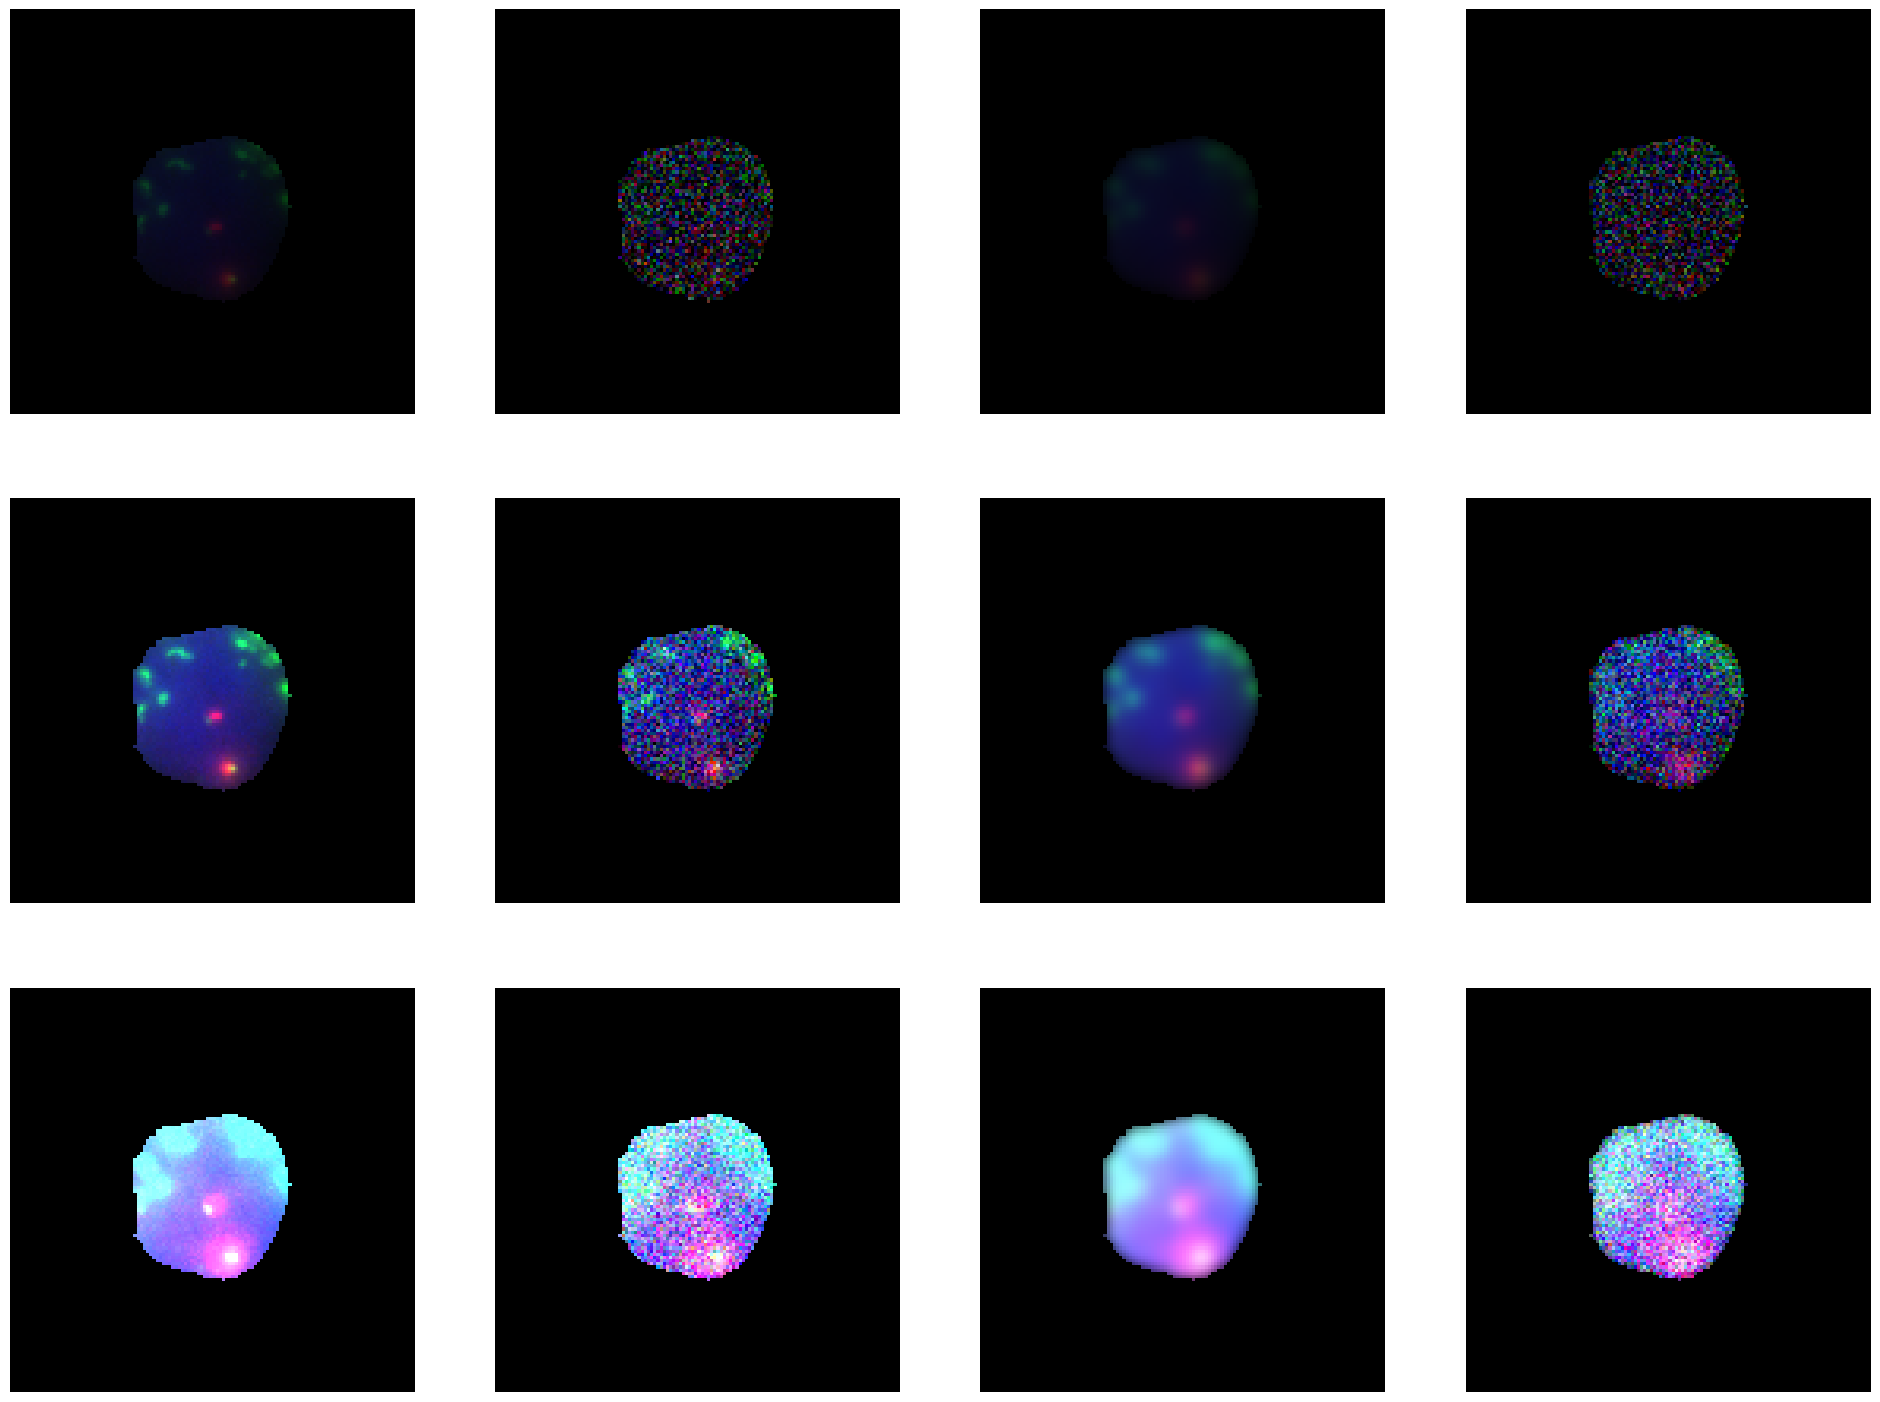

In [66]:
fig, ax = plt.subplots(3, 4, figsize=(24,18))

for a, im in zip(ax.ravel(), df.image):
    a.imshow(im)
    a.axis("off")
    
plt.savefig("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/DEGRADED/EXAMPLE.eps")